<a href="https://colab.research.google.com/github/Somnath1998g/Projects/blob/main/Sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales prediction
Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality.

With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. We are provided with historical sales data for 1,115 Rossmann stores.

##Downloading the Data

In [1]:
!pip install numpy pandas-profiling matplotlib seaborn --quiet


In [2]:
!pip install opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet

In [3]:
import os
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 120)


In [4]:
od.download("https://www.kaggle.com/c/rossmann-store-sales/data")

100%|██████████| 6.99M/6.99M [00:00<00:00, 13.8MB/s]



Extracting archive ./rossmann-store-sales/rossmann-store-sales.zip to ./rossmann-store-sales


In [5]:
os.listdir("rossmann-store-sales")

['test.csv', 'store.csv', 'train.csv', 'sample_submission.csv']

Now let's load the data into pandas dataframe.

In [6]:
ross_df = pd.read_csv('./rossmann-store-sales/train.csv', low_memory=False)
store_df = pd.read_csv('./rossmann-store-sales/store.csv')
test_df = pd.read_csv('./rossmann-store-sales/test.csv')

In [7]:
ross_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [8]:
test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [9]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [10]:
store_df.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

Now we marge our data of store_df to test_df and train_df.

In [11]:
merged_df = ross_df.merge(store_df, how='left',on= 'Store')
merged_test_df = test_df.merge(store_df , how='left', on ="Store")

In [12]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


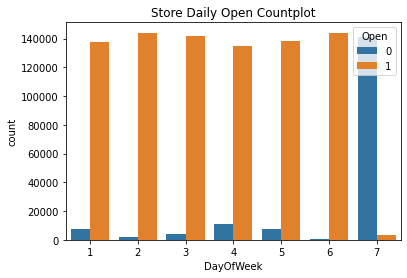

In [13]:
# check stores open distribution on days of week
import seaborn as sns
sns.countplot(x = 'DayOfWeek', hue = 'Open', data = merged_df);
plt.title('Store Daily Open Countplot');

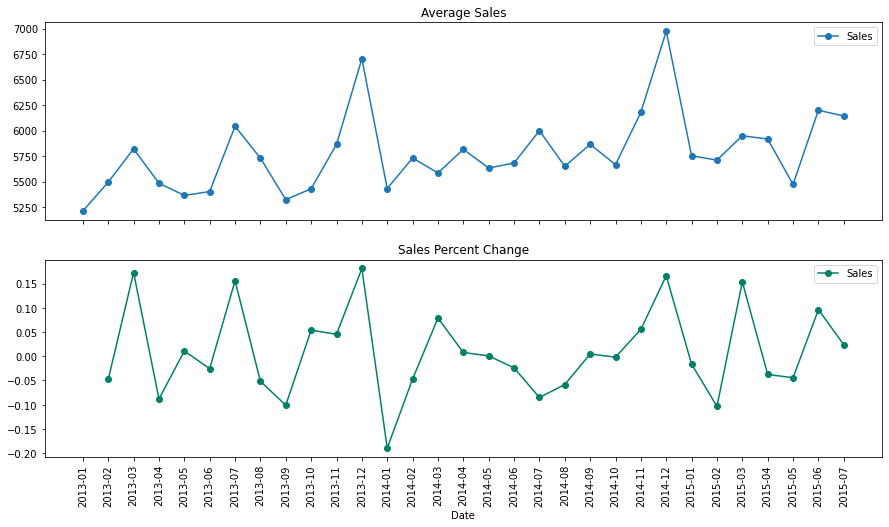

In [14]:
# Create Year and Month columns
merged_df['Year']  = merged_df['Date'].apply(lambda x: int(str(x)[:4]))
merged_df['Month'] = merged_df['Date'].apply(lambda x: int(str(x)[5:7]))

test_df['Year']  = test_df['Date'].apply(lambda x: int(str(x)[:4]))
test_df['Month'] = test_df['Date'].apply(lambda x: int(str(x)[5:7]))

# Assign Date column to Date(Year-Month) instead of (Year-Month-Day)
# this column will be useful in analysis and visualization
merged_df['Date'] = merged_df['Date'].apply(lambda x: (str(x)[:7]))
test_df['Date']     = test_df['Date'].apply(lambda x: (str(x)[:7]))

# group by date and get average sales, and precent change
average_sales    = merged_df.groupby('Date')["Sales"].mean()
pct_change_sales = merged_df.groupby('Date')["Sales"].sum().pct_change()

fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))

# plot average sales over time(year-month)
ax1 = average_sales.plot(legend=True,ax=axis1,marker='o',title="Average Sales")
ax1.set_xticks(range(len(average_sales)))
ax1.set_xticklabels(average_sales.index.tolist(), rotation=90)

# plot precent change for sales over time(year-month)
ax2 = pct_change_sales.plot(legend=True,ax=axis2,marker='o',rot=90,colormap="summer",title="Sales Percent Change")

In [15]:
merged_df.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
Year                              0
Month                             0
dtype: int64

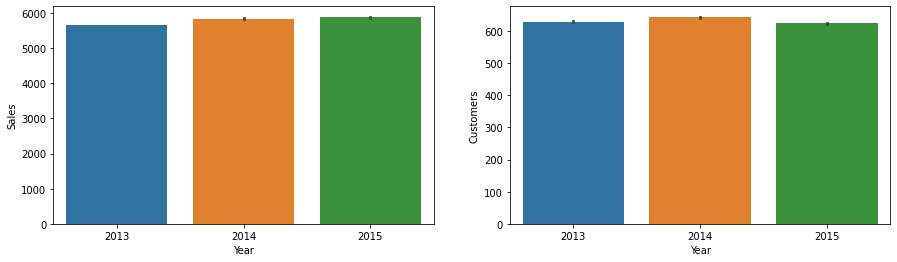

In [16]:
# Create Year columns
merged_df['Year']  = merged_df['Date'].apply(lambda x: int(str(x)[:4]))
# Plot average sales & customers for every year
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Year', y='Sales', data = merged_df, ax=axis1);
sns.barplot(x='Year', y='Customers', data = merged_df, ax=axis2);

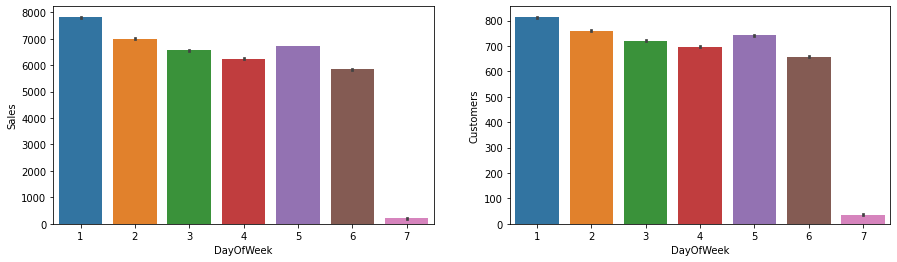

In [17]:
# DayOfWeek
# In both the cases when the store is opened or closed 

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='DayOfWeek', y='Sales', data=merged_df, order=[1,2,3,4,5,6,7], ax=axis1,);
sns.barplot(x='DayOfWeek', y='Customers', data=merged_df, order=[1,2,3,4,5,6,7], ax=axis2);

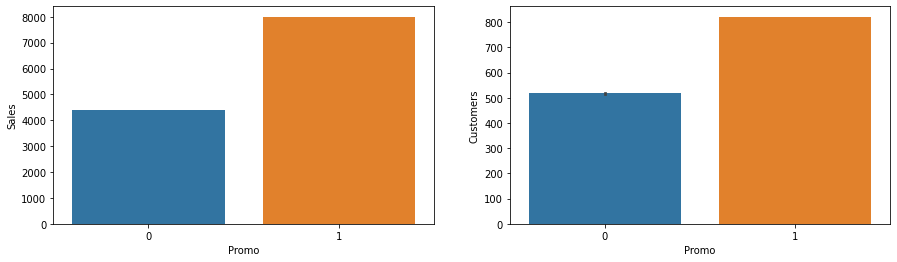

In [18]:
# Promo

# Plot average sales & customers with/without promo
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Promo', y='Sales', data=merged_df, ax=axis1);
sns.barplot(x='Promo', y='Customers', data=merged_df, ax=axis2);

<Axes: xlabel='StoreType', ylabel='Customers'>

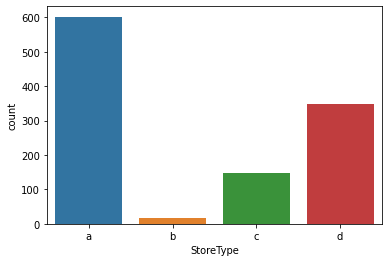

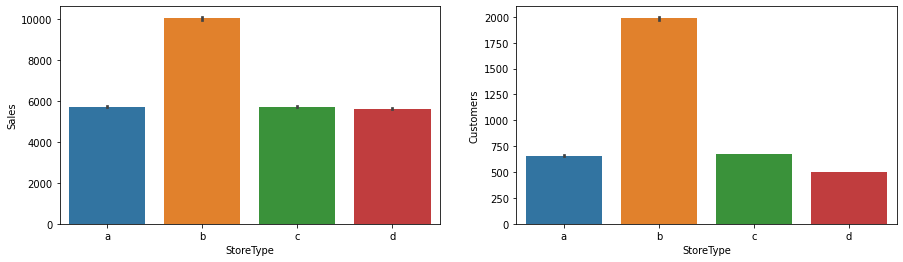

In [19]:
# StoreType 

# Plot StoreType, & StoreType Vs average sales and customers

sns.countplot(x='StoreType', data=store_df, order=['a','b','c', 'd'])

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='StoreType', y='Sales', data=merged_df, order=['a','b','c', 'd'],ax=axis1)
sns.barplot(x='StoreType', y='Customers', data=merged_df, order=['a','b','c', 'd'], ax=axis2)

<ipython-input-20-9878dd6cac1f>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g1 = sns.distplot(merged_df['Sales'],hist = True,label='skewness:{:.2f}'.format(merged_df['Sales'].skew()),ax = ax1)
<ipython-input-20-9878dd6cac1f>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g2 = sns.distplot(np.log1p(merged_df['Sales

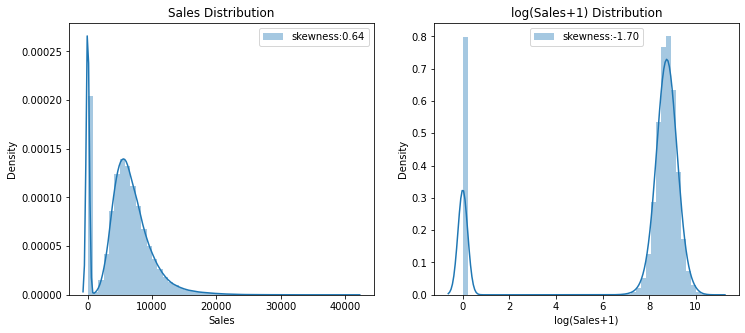

In [20]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
g1 = sns.distplot(merged_df['Sales'],hist = True,label='skewness:{:.2f}'.format(merged_df['Sales'].skew()),ax = ax1)
g1.legend()
g1.set(xlabel = 'Sales', ylabel = 'Density', title = 'Sales Distribution')
g2 = sns.distplot(np.log1p(merged_df['Sales']),hist = True,label='skewness:{:.2f}'.format(np.log1p(merged_df['Sales']).skew()),ax=ax2)
g2.legend()
g2.set(xlabel = 'log(Sales+1)',ylabel = 'Density', title = 'log(Sales+1) Distribution')
plt.show()

Here we have some outlier because of sales have to two type values either zero or non zero.

In [21]:
merged_df[merged_df.Open == 0].Sales.value_counts()

0    172817
Name: Sales, dtype: int64

So we remove the the rows when open==0.

In [22]:
merged_df = merged_df[merged_df.Open == 1].copy()

<ipython-input-23-9878dd6cac1f>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g1 = sns.distplot(merged_df['Sales'],hist = True,label='skewness:{:.2f}'.format(merged_df['Sales'].skew()),ax = ax1)
<ipython-input-23-9878dd6cac1f>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g2 = sns.distplot(np.log1p(merged_df['Sales

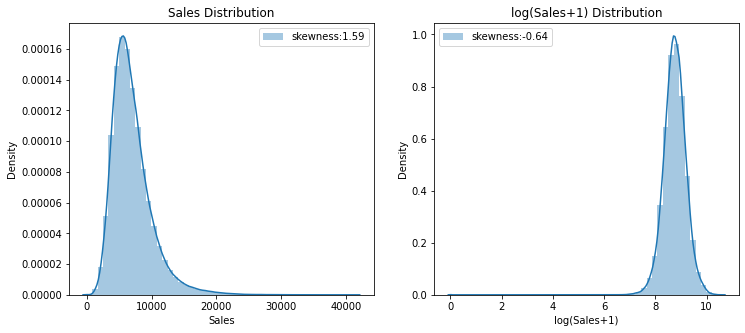

In [23]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
g1 = sns.distplot(merged_df['Sales'],hist = True,label='skewness:{:.2f}'.format(merged_df['Sales'].skew()),ax = ax1)
g1.legend()
g1.set(xlabel = 'Sales', ylabel = 'Density', title = 'Sales Distribution')
g2 = sns.distplot(np.log1p(merged_df['Sales']),hist = True,label='skewness:{:.2f}'.format(np.log1p(merged_df['Sales']).skew()),ax=ax2)
g2.legend()
g2.set(xlabel = 'log(Sales+1)',ylabel = 'Density', title = 'log(Sales+1) Distribution')
plt.show()

## Preprocessing and Feature Engineering
Let's take a look at the available columns, and figure out if we can create new columns or apply any useful transformations.

In [24]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844392 non-null  int64  
 1   DayOfWeek                  844392 non-null  int64  
 2   Date                       844392 non-null  object 
 3   Sales                      844392 non-null  int64  
 4   Customers                  844392 non-null  int64  
 5   Open                       844392 non-null  int64  
 6   Promo                      844392 non-null  int64  
 7   StateHoliday               844392 non-null  object 
 8   SchoolHoliday              844392 non-null  int64  
 9   StoreType                  844392 non-null  object 
 10  Assortment                 844392 non-null  object 
 11  CompetitionDistance        842206 non-null  float64
 12  CompetitionOpenSinceMonth  575773 non-null  float64
 13  CompetitionOpenSinceYear   5

In [25]:
merged_df.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2186
CompetitionOpenSinceMonth    268619
CompetitionOpenSinceYear     268619
Promo2                            0
Promo2SinceWeek              423307
Promo2SinceYear              423307
PromoInterval                423307
Year                              0
Month                             0
dtype: int64

### Date
First, let's convert Date to a datetime column and extract different parts of the date.

In [26]:
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [27]:
split_date(merged_df)
split_date(merged_test_df)

In [28]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-01,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,1,27
1,2,5,2015-07-01,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,1,27
2,3,5,2015-07-01,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,1,27
3,4,5,2015-07-01,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,1,27
4,5,5,2015-07-01,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,1,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1,b,a,150.0,9.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1
1016827,733,2,2013-01-01,10765,2377,1,0,a,1,b,b,860.0,10.0,1999.0,0,NaN,NaN,NaN,2013,1,1,1
1016863,769,2,2013-01-01,5035,1248,1,0,a,1,b,b,840.0,NaN,NaN,1,48.0,2012.0,"Jan,Apr,Jul,Oct",2013,1,1,1
1017042,948,2,2013-01-01,4491,1039,1,0,a,1,b,b,1430.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1


### Competition
Next, we can use the columns CompetitionOpenSince[Month/Year] columns from store_df to compute the number of months for which a competitor has been open near the store.

In [29]:
def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [30]:
comp_months(merged_df)
comp_months(merged_test_df)

In [31]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen
0,1,5,2015-07-01,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,1,27,82.0
1,2,5,2015-07-01,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,1,27,92.0
2,3,5,2015-07-01,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,1,27,103.0
3,4,5,2015-07-01,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,1,27,70.0
4,5,5,2015-07-01,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,1,27,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1,b,a,150.0,9.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1,76.0
1016827,733,2,2013-01-01,10765,2377,1,0,a,1,b,b,860.0,10.0,1999.0,0,NaN,NaN,NaN,2013,1,1,1,159.0
1016863,769,2,2013-01-01,5035,1248,1,0,a,1,b,b,840.0,NaN,NaN,1,48.0,2012.0,"Jan,Apr,Jul,Oct",2013,1,1,1,0.0
1017042,948,2,2013-01-01,4491,1039,1,0,a,1,b,b,1430.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1,0.0


Let's view the results of the new columns we've created.

In [32]:
merged_df[['Date', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpen']].sample(20)

,Date,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpen
170845,2015-02-01,340.0,NaN,NaN,0.0
412492,2014-06-01,13990.0,NaN,NaN,0.0
611144,2013-12-01,12480.0,NaN,NaN,0.0
28451,2015-07-01,2270.0,NaN,NaN,0.0
990260,2013-01-01,5150.0,2011.0,3.0,22.0
286311,2014-11-01,120.0,2014.0,12.0,0.0
145291,2015-03-01,15770.0,NaN,NaN,0.0
566947,2014-02-01,290.0,2002.0,9.0,137.0
775879,2013-08-01,1170.0,2011.0,4.0,28.0
283885,2014-11-01,250.0,NaN,NaN,0.0


### Additional Promotion
We can also add some additional columns to indicate how long a store has been running Promo2 and whether a new round of Promo2 starts in the current month.

In [33]:
merged_df['Promo2Open'] = 12 * (merged_df.Year - merged_df.Promo2SinceYear) +  (merged_df.WeekOfYear - merged_df.Promo2SinceWeek)*7/30.5
merged_df['Promo2Open'] = merged_df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * merged_df['Promo2']

In [34]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,Promo2Open
0,1,5,2015-07-01,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,1,27,82.0,0.000000
1,2,5,2015-07-01,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,1,27,92.0,63.213115
2,3,5,2015-07-01,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,1,27,103.0,50.983607
3,4,5,2015-07-01,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,1,27,70.0,0.000000
4,5,5,2015-07-01,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,1,27,3.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1,b,a,150.0,9.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1,76.0,0.000000
1016827,733,2,2013-01-01,10765,2377,1,0,a,1,b,b,860.0,10.0,1999.0,0,NaN,NaN,NaN,2013,1,1,1,159.0,0.000000
1016863,769,2,2013-01-01,5035,1248,1,0,a,1,b,b,840.0,NaN,NaN,1,48.0,2012.0,"Jan,Apr,Jul,Oct",2013,1,1,1,0.0,1.213115
1017042,948,2,2013-01-01,4491,1039,1,0,a,1,b,b,1430.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1,0.0,0.000000


In [35]:
merged_test_df['Promo2Open'] = 12 * (merged_test_df.Year - merged_test_df.Promo2SinceYear) +  (merged_test_df.WeekOfYear - merged_test_df.Promo2SinceWeek)*7/30.5
merged_test_df['Promo2Open'] = merged_test_df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * merged_test_df['Promo2']
    

In [36]:
merged_test_df[:3]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,Promo2Open
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,9,17,38,84.0,0.000000
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,9,17,38,105.0,53.508197
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN,2015,9,17,38,29.0,0.000000


In [37]:
merged_test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,Promo2Open
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,9,17,38,84.0,0.000000
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,9,17,38,105.0,53.508197
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN,2015,9,17,38,29.0,0.000000
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN,2015,9,17,38,11.0,0.000000
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN,2015,9,17,38,181.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2015,8,1,31,14.0,24.000000
41084,41085,1112,6,2015-08-01,1.0,0,0,0,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,2015,8,1,31,112.0,0.000000
41085,41086,1113,6,2015-08-01,1.0,0,0,0,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,2015,8,1,31,0.0,0.000000
41086,41087,1114,6,2015-08-01,1.0,0,0,0,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,2015,8,1,31,0.0,0.000000


In [38]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,Promo2Open
0,1,5,2015-07-01,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,1,27,82.0,0.000000
1,2,5,2015-07-01,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,1,27,92.0,63.213115
2,3,5,2015-07-01,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,1,27,103.0,50.983607
3,4,5,2015-07-01,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,1,27,70.0,0.000000
4,5,5,2015-07-01,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,1,27,3.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1,b,a,150.0,9.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1,76.0,0.000000
1016827,733,2,2013-01-01,10765,2377,1,0,a,1,b,b,860.0,10.0,1999.0,0,NaN,NaN,NaN,2013,1,1,1,159.0,0.000000
1016863,769,2,2013-01-01,5035,1248,1,0,a,1,b,b,840.0,NaN,NaN,1,48.0,2012.0,"Jan,Apr,Jul,Oct",2013,1,1,1,0.0,1.213115
1017042,948,2,2013-01-01,4491,1039,1,0,a,1,b,b,1430.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1,0.0,0.000000


Here we fill na Nan values with blank values.

In [39]:
merged_df['PromoInterval']=merged_df['PromoInterval'].fillna('')
merged_test_df['PromoInterval']=merged_test_df['PromoInterval'].fillna('')

In [40]:
merged_df.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2186
CompetitionOpenSinceMonth    268619
CompetitionOpenSinceYear     268619
Promo2                            0
Promo2SinceWeek              423307
Promo2SinceYear              423307
PromoInterval                     0
Year                              0
Month                             0
Day                               0
WeekOfYear                        0
CompetitionOpen                   0
Promo2Open                        0
dtype: int64

In [41]:
def build_features(features, data):
    features.append('IsPromoMonth')
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    merged_df['monthStr'] = merged_df.Month.map(month2str)
    merged_df.loc[merged_df.PromoInterval==0, 'PromoInterval'] = ''
    merged_df['IsPromoMonth'] = 0
    merged_test_df['monthStr'] = merged_test_df.Month.map(month2str)
    merged_test_df.loc[merged_test_df.PromoInterval==0, 'PromoInterval'] = ''
    merged_test_df['IsPromoMonth'] = 0
    
    for interval in merged_df.PromoInterval.unique():
        if interval != '':
          try:
               for month in interval.split(','):
                   merged_df.loc[(merged_df.monthStr == month) & (merged_df.PromoInterval == interval), 'IsPromoMonth'] = 1
          except Exception:
                return 0 
    for interval in merged_test_df.PromoInterval.unique():
        if interval != '':
          try:
               for month in interval.split(','):
                   merged_test_df.loc[(merged_test_df.monthStr == month) & (merged_test_df.PromoInterval == interval), 'IsPromoMonth'] = 1
          except Exception:
                return 0                               
                

In [42]:
merged_df.Date = pd.to_datetime(merged_df.Date, errors='coerce')
merged_test_df.Date = pd.to_datetime(merged_test_df.Date, errors='coerce')


features = []


build_features(features, merged_df)
build_features([], merged_test_df)


print(features)

['IsPromoMonth']


In [43]:
merged_df['IsPromoMonth'].value_counts()


0    699164
1    145228
Name: IsPromoMonth, dtype: int64

In [44]:
merged_test_df['IsPromoMonth'].value_counts()

0    35852
1     5236
Name: IsPromoMonth, dtype: int64

In [45]:
merged_df[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromoMonth']].sample(20)

,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromoMonth
180350,2015-02-01,0,NaN,NaN,,0.000000,0
237944,2014-12-01,0,NaN,NaN,,0.000000,0
48293,2015-06-01,0,NaN,NaN,,0.000000,0
738564,2013-09-01,1,2013.0,23.0,"Mar,Jun,Sept,Dec",2.754098,1
365170,2014-08-01,1,2014.0,10.0,"Mar,Jun,Sept,Dec",4.819672,0
742112,2013-09-01,1,2010.0,13.0,"Jan,Apr,Jul,Oct",41.049180,0
315432,2014-10-01,0,NaN,NaN,,0.000000,0
72086,2015-05-01,0,NaN,NaN,,0.000000,0
460178,2014-05-01,0,NaN,NaN,,0.000000,0
825796,2013-06-01,0,NaN,NaN,,0.000000,0


The features related to competition and promotion are now much more useful.

### Input and Target columns

Let's select the columns that we'll use for training.

In [46]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'monthStr',
       'IsPromoMonth'],
      dtype='object')

In [47]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2', 
              'Promo2Open', 'IsPromoMonth']
target_col = 'Sales'

In [48]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()

In [49]:
test_inputs = merged_test_df[input_cols].copy()

Let's also identify numeric and categorical columns. Note that we can treat binary categorical columns (0/1) as numeric columns.

In [50]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromoMonth',
              'Day', 'Month', 'Year', 'WeekOfYear',  ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

### Imputing missing numerical data

In [51]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromoMonth              0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
dtype: int64

In [52]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromoMonth            0
Day                     0
Month                   0
Year                    0
WeekOfYear              0
dtype: int64

Seems like competition distance is the only missing value, and we can simply fill it with the highest value (to indicate that competition is very far away).

In [53]:
max_distance = inputs.CompetitionDistance.max()

In [54]:
inputs['CompetitionDistance'].fillna(max_distance, inplace=True)
test_inputs['CompetitionDistance'].fillna(max_distance, inplace=True)

### Scale Numeric Values
Let's scale numeric values to the 0 to 1 range.

In [55]:
from sklearn.preprocessing import MinMaxScaler

In [56]:
scaler = MinMaxScaler().fit(inputs[numeric_cols])

In [57]:
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

### Encode Catagorical Columns

In [58]:
from sklearn.preprocessing import OneHotEncoder

In [59]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [60]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

Finally, let's extract out all the numeric data for training.

In [61]:
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

## Training
To train a GBM, we can use the XGBRegressor class from the XGBoost library.

In [62]:
from xgboost import XGBRegressor

In [63]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=240,
                     max_depth=10,learning_rate=0.9)

In [64]:
%%time
model.fit(X, targets)

CPU times: user 14min 39s, sys: 1.99 s, total: 14min 41s
Wall time: 8min 7s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.9, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=240, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

## Prediction
We can now make predictions and evaluate the model using model.predict.

In [65]:
preds = model.predict(X)

In [66]:
preds

array([5303.8853, 5441.016 , 7590.7256, ..., 5069.639 , 4696.522 ,
       6143.7104], dtype=float32)

## Evaluation
Let's evaluate the predictions using RMSE error.

In [67]:
from sklearn.metrics import mean_squared_error

def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [68]:
rmse(preds, targets)

726.6159512555197

So we can see the RMSE error is 726.62

## Feature importance
Just like decision trees and random forests, XGBoost also provides a feature importance score for each column in the input.

In [69]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [70]:
importance_df.head(10)

,feature,importance
24,StoreType_b,0.370377
5,Promo2,0.084325
18,DayOfWeek_7,0.066476
27,Assortment_a,0.064150
29,Assortment_c,0.053164
3,CompetitionDistance,0.049258
1,Promo,0.044962
0,Store,0.039414
23,StoreType_a,0.033985
26,StoreType_d,0.029091


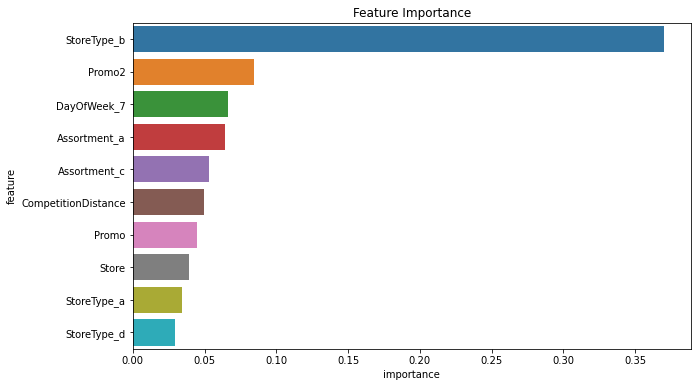

In [71]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

So we can see that StoreType_b is the most important feature.

So the final result is our RMSE value for train set is 726.62. Which is not a big error with respect to this data.

## K-fold cross validation
Here we didn't create a validation set before training our XGBoost model. K-fold cross validation strategy we will use now.

In [72]:
from sklearn.model_selection import KFold

Let's define a function train_and_evaluate which trains a model the given parameters and returns the trained model, training error and validation error.

In [73]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse

Now, we can use the KFold utility to create the different training/validations splits and train a separate model for each fold.

In [74]:
kfold = KFold(n_splits=5)

In [76]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_train, 
                                                     train_targets, 
                                                     X_val, 
                                                     val_targets, 
                                                     n_estimators=150,
                                                     max_depth=10,learning_rate=0.9)
    models.append(model)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

Train RMSE: 768.2022585241382, Validation RMSE: 1419.4129012678031
Train RMSE: 740.5721261235967, Validation RMSE: 1628.070044519239
Train RMSE: 761.7943472129907, Validation RMSE: 1291.6630316994087
Train RMSE: 731.2076244044451, Validation RMSE: 1748.5654420133974
Train RMSE: 757.2297516162004, Validation RMSE: 1428.6581880228136


In [77]:
def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [78]:
preds = predict_avg(models, X)

In [79]:
preds

array([4822.517 , 5143.5386, 7523.1577, ..., 5571.329 , 5296.8545,
       6472.3516], dtype=float32)

In [80]:
rmse(preds, targets)

772.365276506059

Since it may take a long time to perform 5-fold cross validation for each set of parameters we wish to try, we'll just pick a random 10% sample of the dataset as the validation set.

In [81]:
from sklearn.model_selection import train_test_split

In [82]:
X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)

In [83]:
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

In [84]:
test_params(n_estimators=100,max_depth=8,learning_rate=0.7)

Train RMSE: 916.2305419894832, Validation RMSE: 970.0123276112026


In [85]:
test_params(n_estimators=150,max_depth=9,learning_rate=0.8)

Train RMSE: 801.4052591056976, Validation RMSE: 947.1696866292363


In [86]:
test_params(n_estimators=200,max_depth=10,learning_rate=0.9)

Train RMSE: 732.267955726306, Validation RMSE: 1011.7756771628916


In [87]:
test_params(n_estimators=200,max_depth=6,learning_rate=0.8)

Train RMSE: 942.4151371233642, Validation RMSE: 966.8512830270448
